In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns',None) # To display all columns
pd.set_option('display.max_rows',None) # To display all columns
import feather
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')
from functools import reduce

In [2]:
KT1 = pd.read_feather('s3://haseebdata/EDNET DATA/Ednet feather files/KT1.ftr')
#KT3 = pd.read_feather('KT3.ftr')

In [3]:
questions_df = pd.read_csv('s3://haseebdata/EDNET DATA/EDNET Content CSV/questions.csv')

In [4]:
KT1.head()

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_iD
0,1565096190868,1,q5012,b,38000,1
1,1565096221062,2,q4706,c,24000,1
2,1565096293432,3,q4366,b,68000,1
3,1565096339668,4,q4829,a,42000,1
4,1565096401774,5,q6528,b,59000,1


In [5]:
KT1['user_iD'].unique()

array([   1,   10,  100, ..., 9994, 9995, 9998], dtype=int32)

In [6]:
questions_df.bundle_id = questions_df.bundle_id.str.slice(start=1)
questions_df.explanation_id = questions_df.explanation_id.str.slice(start=1)
questions_df.deployed_at = pd.to_datetime(questions_df.deployed_at, unit='ms')
dfq = questions_df[['question_id', 'correct_answer', 'bundle_id', 'explanation_id' , 'part', 'tags', 'deployed_at']]
#dfq.head()

In [7]:
# subset df for notnull question_id rows only (only work with rows that have questions)
df2 = KT1[KT1['question_id'].notnull()]

In [8]:
# left join student dataframe and answer key dataframe on the 'question_id' column 
dfm = pd.merge(df2, dfq,  how='left', left_on=['question_id'], right_on = ['question_id'])

In [9]:
dfm.head()

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_iD,correct_answer,bundle_id,explanation_id,part,tags,deployed_at
0,1565096190868,1,q5012,b,38000,1,c,3544,3544,5,74,2019-09-17 02:43:28.616
1,1565096221062,2,q4706,c,24000,1,c,3238,3238,5,71,2019-10-30 05:34:30.723
2,1565096293432,3,q4366,b,68000,1,b,2898,2898,5,103,2019-10-30 05:37:51.451
3,1565096339668,4,q4829,a,42000,1,c,3361,3361,5,83,2019-06-24 09:24:51.347
4,1565096401774,5,q6528,b,59000,1,d,5060,5060,5,90,2019-10-17 03:03:15.009


In [10]:
# create a 'correct' column
dfm['correct'] = np.nan

# loop - if user answers == correct answer, then dfq['correct'][_]= 1
length_df = dfm['user_iD'].count()
count = 0
for i in range(length_df):
    if dfm['user_answer'][count] == dfm['correct_answer'][count]:
        dfm['correct'][count] = 1
    if dfm['user_answer'][count] != dfm['correct_answer'][count]:
        dfm['correct'][count] = 0
    count+=1

In [11]:
dfm_userid_counts = dfm.user_iD.value_counts()
mask = dfm_userid_counts >= 30
dfm_userids = mask[mask].index

dfm = dfm[dfm.user_iD.isin(dfm_userids)]

In [12]:
df_total_questions_attempted = dfm.groupby(['user_iD'], as_index=False , sort=False)['question_id'].count()

df_total_questions_attempted = df_total_questions_attempted.rename(columns={'question_id': 'Total Questions Attempted'})

df_total_questions_attempted.head()                                                                

,user_iD,Total Questions Attempted
0,1,1082
1,100,33
2,1000,1488
3,10004,2486
4,100043,714


In [13]:
df_total_questions_attempted['user_iD'].unique()

array([   1,  100, 1000, ..., 9994, 9995, 9998])

In [14]:
df_correct = dfm[dfm['correct']==1].groupby(['user_iD'], as_index=False, sort=False)['question_id'].count()

df_correct = df_correct.rename(columns={'question_id': 'Corrected'})

df_correct.head()

,user_iD,Corrected
0,1,753
1,100,18
2,1000,930
3,10004,1790
4,100043,328


In [15]:
df_incorrect = dfm[dfm['correct']==0].groupby(['user_iD'], as_index=False, sort=False)['question_id'].count()

df_incorrect = df_incorrect.rename(columns={'question_id': 'Incorrected'})

df_incorrect.head()

,user_iD,Incorrected
0,1,329
1,100,15
2,1000,558
3,10004,696
4,100043,386


In [16]:
dfs = [df_total_questions_attempted, df_correct, df_incorrect]
df_final = reduce(lambda left,right: pd.merge(left,right,on='user_iD'), dfs)

In [17]:
df_final.head()

,user_iD,Total Questions Attempted,Corrected,Incorrected
0,1,1082,753,329
1,100,33,18,15
2,1000,1488,930,558
3,10004,2486,1790,696
4,100043,714,328,386


In [18]:
df_final['Percentage'] = (df_final['Corrected'] / df_final['Total Questions Attempted']) *100
df_final.head()

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage
0,1,1082,753,329,69.593346
1,100,33,18,15,54.545455
2,1000,1488,930,558,62.500000
3,10004,2486,1790,696,72.003218
4,100043,714,328,386,45.938375


In [19]:
df_final.to_feather('Users.ftr')

In [20]:
df_final[0:50]

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage
0,1,1082,753,329,69.593346
1,100,33,18,15,54.545455
2,1000,1488,930,558,62.500000
3,10004,2486,1790,696,72.003218
4,100043,714,328,386,45.938375
5,10005,1439,986,453,68.519805
6,10010,305,191,114,62.622951
7,10011,763,544,219,71.297510
8,10013,145,79,66,54.482759
9,10014,751,555,196,73.901465


In [21]:
df_85 = df_final.loc[df_final['Percentage'] >= 85]

In [22]:
df_85[0:50]

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage
51,10109,2587,2283,304,88.248937
213,10411,7414,6844,570,92.311842
287,10553,802,740,62,92.269327
316,10613,880,805,75,91.477273
375,10724,55,48,7,87.272727
413,10783,1216,1041,175,85.608553
523,11011,7286,6265,1021,85.986824
581,11132,1648,1408,240,85.436893
670,11324,1276,1128,148,88.401254
972,11957,705,600,105,85.106383


In [23]:
df_90 = df_final.loc[df_final['Percentage'] >= 90]

<AxesSubplot:xlabel='user_iD'>

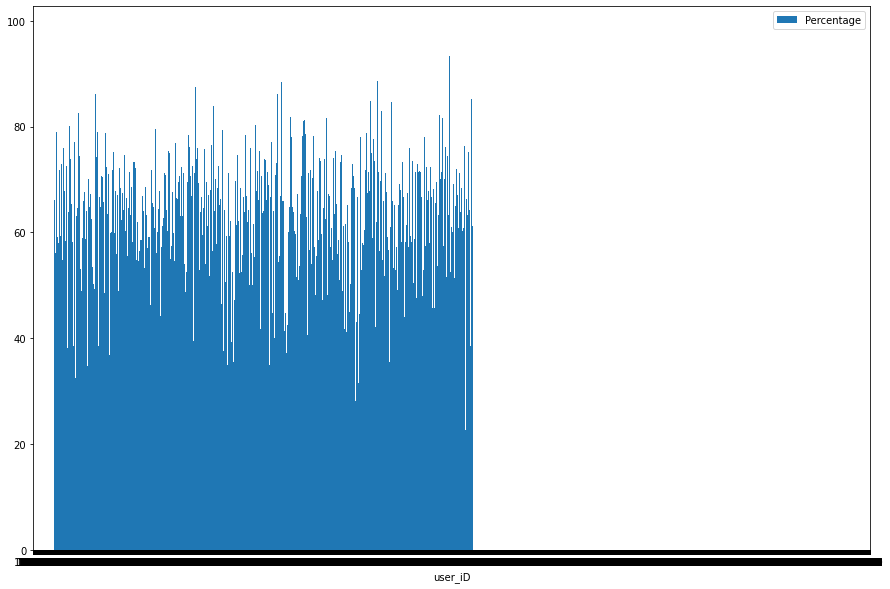

In [24]:
df_final.plot(x="user_iD", y=["Percentage"], kind="bar",figsize=(15,10) , rot=0)

In [25]:
Users_90_percent_more = df_final.loc[df_final['Percentage'] >= 95]

<AxesSubplot:xlabel='user_iD'>

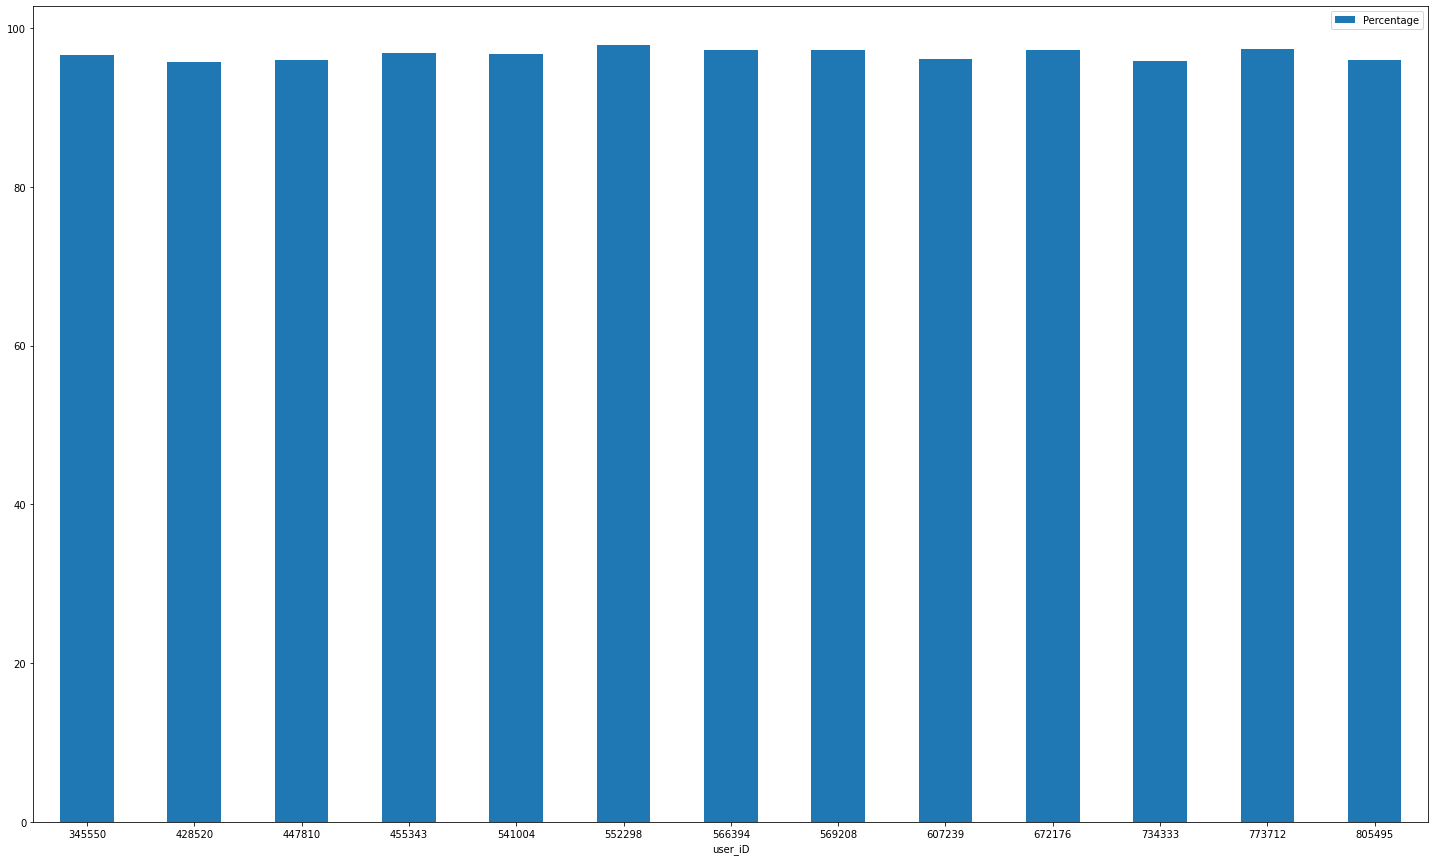

In [26]:
Users_90_percent_more.plot(x="user_iD", y=["Percentage"], kind="bar",figsize=(25,15) , rot=0)

In [27]:
dfm['elapsed_time']= dfm.elapsed_time.div(1000)

In [28]:
Elapsed_time= dfm.groupby('user_iD' , sort=False)['elapsed_time'].mean()

Text(0.5, 0, 'USERS')

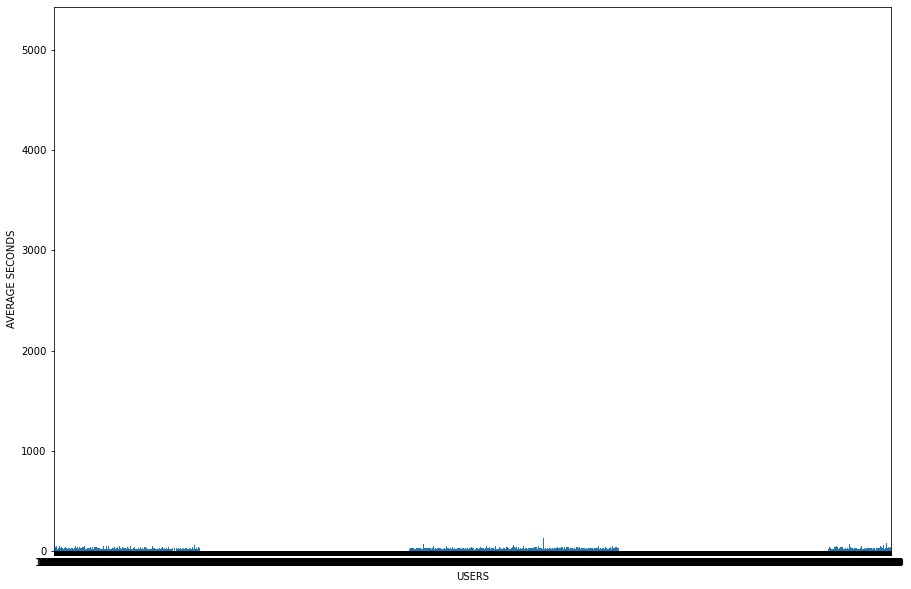

In [29]:
Elapsed_time.plot(kind="bar",figsize=(15,10) , rot=0)
plt.ylabel('AVERAGE SECONDS')
plt.xlabel('USERS')